# Feature Selection

This notebook explores the dataset's columns which provide specific flight details, and extracts the features from these columns that will be used in our flight prediction models. We create features from the time based data to specify the time of the year, time of the day, etc. 

In [1]:
import pandas as pd

# Load your dataset
df = pd.read_csv("cleaned_flight_data.csv", encoding="ISO-8859-1", low_memory=False)
df

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum
0,1998,1,1,2,5,1998-01-02,NW,19386,NW,N297US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,2,5,28,4,2009-05-28,FL,20437,FL,N946AT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013,2,6,29,6,2013-06-29,MQ,20398,MQ,N665MQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,3,8,31,2,2010-08-31,DL,19790,DL,N6705Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006,1,1,15,7,2006-01-15,US,20355,US,N504AU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,2008,1,3,23,7,2008-03-23,WN,19393,WN,N712SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999996,1999,1,1,5,2,1999-01-05,CO,19704,CO,N14308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999997,2003,4,11,14,5,2003-11-14,US,20355,US,N528AU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999998,2012,2,5,15,2,2012-05-15,WN,19393,WN,N281WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## How is Delay defined in the dataset?

The columns `CRSDepTime` and `CRSArrTime` gives the scheduled times for departure and arrival of the given flight, while the `DepTime` and `ArrTime` columns gives the actual time of departure and arrival for the flight. The columns `DepDelay` and `ArrDelay` represents the difference between the values in these columns respectively, with negative values indicating that the departure or arrival time of the flight was earlier than expected and positive values indicating the amount of delay time that was experienced. Flights with no delay consequently has their values in these delay columns as 0. 

- `DepDelay` = `CRSDepTime` - `DepTime`

- `ArrDelay` = `CRSArrTime` - `ArrTime`

In [2]:
# ---- Step 1: Basic Feature Selection ----
# Pick only useful columns and make a copy to avoid SettingWithCopyWarning
df_selected = df[[
    'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline',
    'Origin', 'Dest', 'CRSDepTime', 'CRSArrTime',
    'Distance', 'DepDelay', 'ArrDelay', 
    'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'SecurityDelay',
    'Cancelled', 'Diverted'
]].copy()

# ---- Step 2: Create a Delay Label ----
# Target: 1 if either departure OR arrival delay > 0 minutes, else 0
df_selected.loc[:, 'Delay'] = ((df_selected['DepDelay'] > 0) | (df_selected['ArrDelay'] > 0)).astype(int)

# ---- Step 3: Feature Engineering ----

# Create Part of Day
def part_of_day(dep_time):
    if pd.isnull(dep_time):
        return 'Unknown'
    dep_time = int(dep_time)
    if dep_time < 600:
        return 'Early Morning'
    elif dep_time < 1200:
        return 'Morning'
    elif dep_time < 1700:
        return 'Afternoon'
    elif dep_time < 2100:
        return 'Evening'
    else:
        return 'Night'

df_selected.loc[:, 'PartOfDay'] = df_selected['CRSDepTime'].apply(part_of_day)

# Create Total Delay
df_selected.loc[:, 'TotalDelay'] = df_selected[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']].sum(axis=1)

# Create Route
df_selected.loc[:, 'Route'] = df_selected['Origin'] + '_' + df_selected['Dest']

# Weekend flag
df_selected.loc[:, 'IsWeekend'] = df_selected['DayOfWeek'].apply(lambda x: 1 if x in [6,7] else 0)

# ---- Step 4: Drop columns you no longer need ----
df_model = df_selected.drop(['DepDelay', 'ArrDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay'], axis=1)

# ---- Step 5: Check result ----

# Adjust pandas options to display more rows and columns
pd.set_option('display.max_rows', 20)  # Show up to 20 rows (can adjust this number)
pd.set_option('display.max_columns', None)  # Show all columns

# Print the DataFrame to display in a nice table-like format
print(df_model)

         Month  DayofMonth  DayOfWeek Reporting_Airline Origin Dest  \
0            1           2          5                NW    MSP  SLC   
1            5          28          4                FL    MKE  MCO   
2            6          29          6                MQ    GJT  DFW   
3            8          31          2                DL    LAX  DTW   
4            1          15          7                US    EWR  CLT   
...        ...         ...        ...               ...    ...  ...   
1999995      3          23          7                WN    LAS  PHX   
1999996      1           5          2                CO    EWR  DFW   
1999997     11          14          5                US    CHS  CLT   
1999998      5          15          2                WN    MDW  BNA   
1999999      4          29          2                UA    IAD  ORD   

         CRSDepTime  CRSArrTime  Distance  SecurityDelay  Cancelled  Diverted  \
0              1000        1116     991.0            0.0        0.

In [43]:
# If either departure OR arrival delay > 0 minutes, else 0
df_selected.loc[:, 'Delay'] = ((df_selected['DepDelay'] > 0) | (df_selected['ArrDelay'] > 0)).astype(int)

# Create a new column if needed
df_selected['HasNASDelay'] = (df_selected['NASDelay'] > 0).astype(int)

# Now make a crosstab
pd.crosstab(df_selected['HasNASDelay'], df_selected['Delay'], normalize='index')

Delay,0,1
HasNASDelay,,
0,0.501565,0.498435
1,0.000000,1.000000


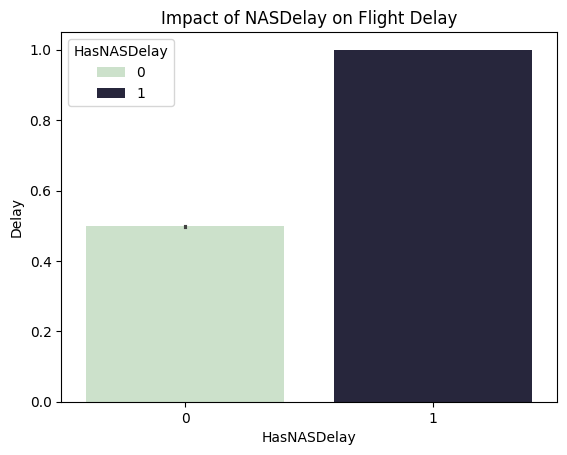

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='HasNASDelay', y='Delay', data=df_selected, palette = 'ch:s=-.4,r=.9', hue='HasNASDelay')
plt.title('Impact of NASDelay on Flight Delay')
plt.show()

In [39]:
# Create a new column if needed
df_selected['HasWeatherDelay'] = (df_selected['WeatherDelay'] > 0).astype(int)

# Now make a crosstab
pd.crosstab(df_selected['HasWeatherDelay'], df_selected['Delay'], normalize='index')

Delay,0,1
HasWeatherDelay,,
0,0.473049,0.526951
1,0.000000,1.000000


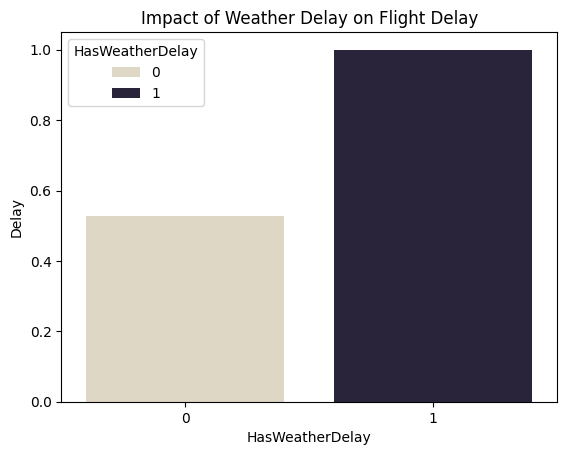

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='HasWeatherDelay', y='Delay', data=df_selected, palette='ch:s=-.2,r=.6', hue='HasWeatherDelay')
plt.title('Impact of Weather Delay on Flight Delay')
plt.show()

In [37]:
# Create a new column if needed
df_selected['HasCarrierDelay'] = (df_selected['CarrierDelay'] > 0).astype(int)

# Now make a crosstab
pd.crosstab(df_selected['HasCarrierDelay'], df_selected['Delay'], normalize='index')

Delay,0,1
HasCarrierDelay,,
0,0.49569,0.50431
1,0.00000,1.00000


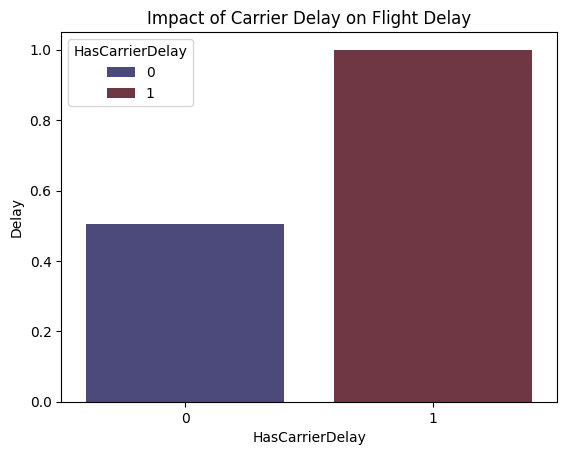

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='HasCarrierDelay', y='Delay', data=df_selected, palette='icefire', hue='HasCarrierDelay')
plt.title('Impact of Carrier Delay on Flight Delay')
plt.show()

In [41]:
# Create a new column if needed
df_selected['HasLateAircraftDelay'] = (df_selected['LateAircraftDelay'] > 0).astype(int)

# Now make a crosstab
pd.crosstab(df_selected['HasLateAircraftDelay'], df_selected['Delay'], normalize='index')

Delay,0,1
HasLateAircraftDelay,,
0,0.496707,0.503293
1,0.000000,1.000000


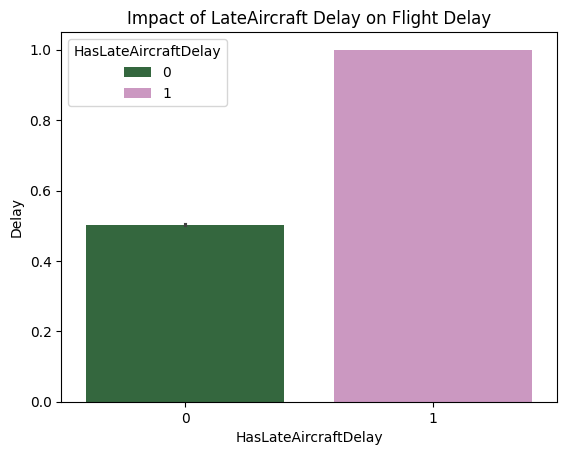

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='HasLateAircraftDelay', y='Delay', data=df_selected, palette='cubehelix', hue='HasLateAircraftDelay')
plt.title('Impact of LateAircraft Delay on Flight Delay')
plt.show()

In [28]:
df_selected.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin',
       'Dest', 'CRSDepTime', 'CRSArrTime', 'Distance', 'DepDelay', 'ArrDelay',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay',
       'SecurityDelay', 'Cancelled', 'Diverted', 'Delay', 'PartOfDay',
       'TotalDelay', 'Route', 'IsWeekend'],
      dtype='object')

In [30]:
# Step 1: Select the needed columns and make a copy to avoid SettingWithCopyWarning
df_selected = df_selected[['SecurityDelay', 'Delay']].copy()

# Create a new column if needed
df_selected['HasSecurityDelay'] = (df_selected['SecurityDelay'] > 0).astype(int)

# Now make a crosstab
pd.crosstab(df_selected['HasSecurityDelay'], df_selected['Delay'], normalize='index')

Delay,0,1
HasSecurityDelay,,
0,0.46998,0.53002
1,0.00000,1.00000


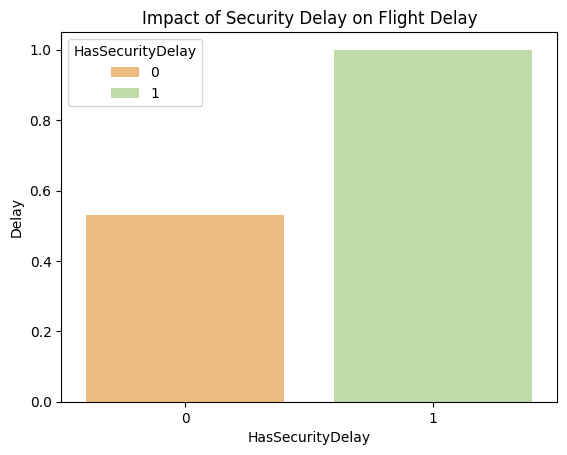

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='HasSecurityDelay', y='Delay', data=df_selected, palette='Spectral', hue='HasSecurityDelay')
plt.title('Impact of Security Delay on Flight Delay')
plt.show()

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column 'DelayOccurred' based on whether the flight was delayed
df['DelayOccurred'] = ((df['DepDelay'] > 0) | (df['ArrDelay'] > 0)).astype(int)

# Check the first few rows to ensure it worked
df[['DepDelay', 'ArrDelay', 'DelayOccurred']].head()

,DepDelay,ArrDelay,DelayOccurred
0,19.0,23.0,1
1,-2.0,0.0,0
2,14.0,-3.0,1
3,0.0,-20.0,0
4,51.0,32.0,1


In [49]:
import pandas as pd
import matplotlib.pyplot as plt

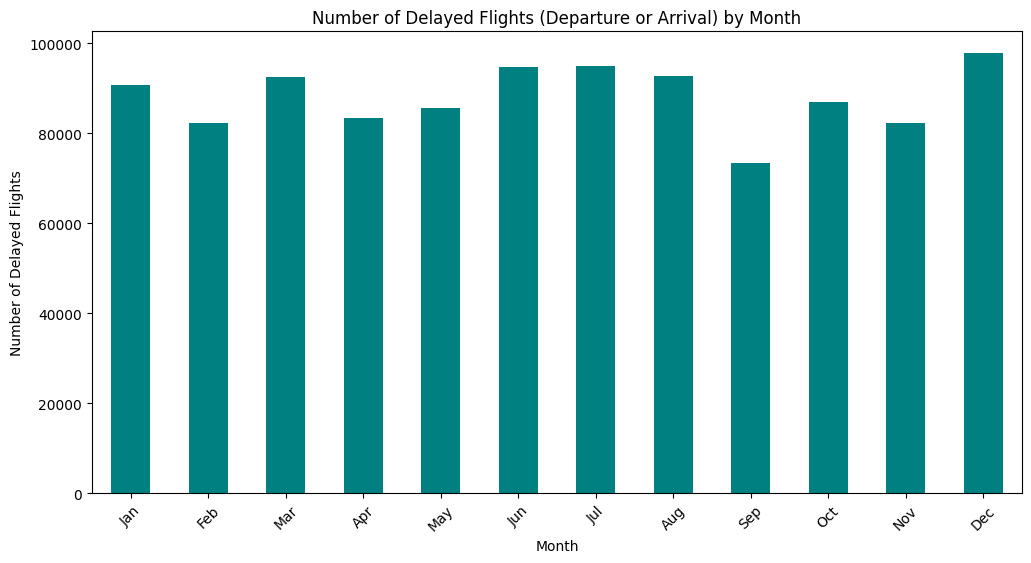

In [ ]:
# Drop rows with NaN values in 'DepDelay', 'ArrDelay', and 'Month'
df = df.dropna(subset=['DepDelay', 'ArrDelay', 'Month'])

# Filter out rows where either departure delay or arrival delay is greater than 0
delayed_flights = df[(df['DepDelay'] > 0) | (df['ArrDelay'] > 0)]

# Calculate the number of delayed flights by month (either DepDelay or ArrDelay > 0)
monthly_delayed_flights = delayed_flights.groupby('Month').size()

# Plot the number of delayed flights by month
plt.figure(figsize=(12, 6))
monthly_delayed_flights.plot(kind='bar', color='teal')
plt.title('Number of Delayed Flights (Departure or Arrival) by Month')
plt.xlabel('Month')
plt.ylabel('Number of Delayed Flights')
plt.xticks(range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()


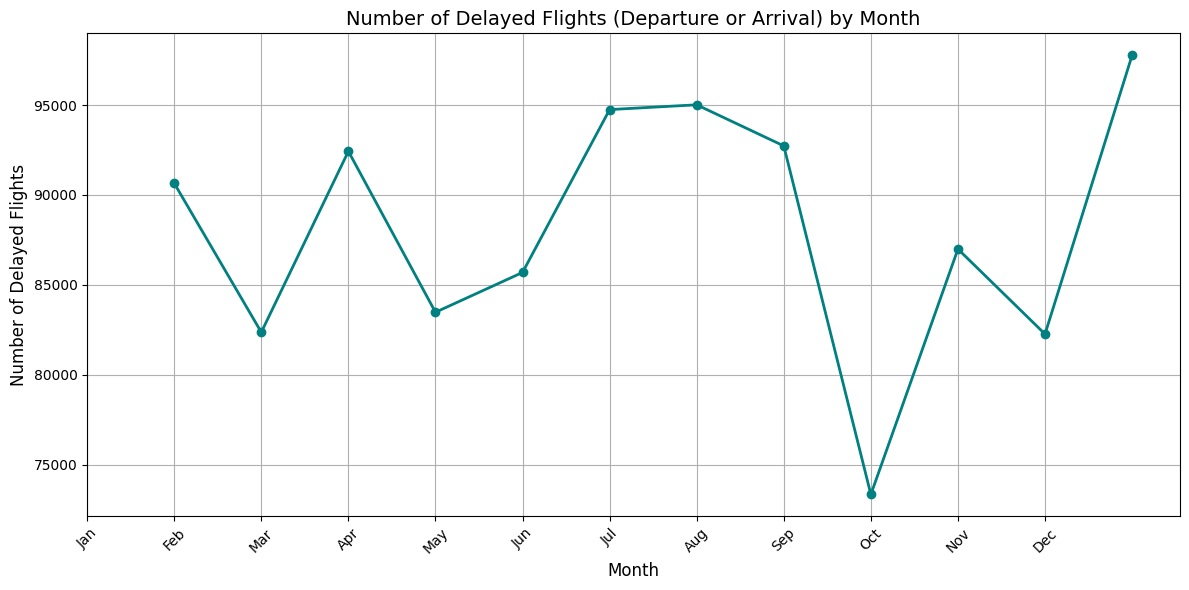

In [ ]:
import matplotlib.pyplot as plt

# Drop rows with NaN values in 'DepDelay', 'ArrDelay', and 'Month'
df = df.dropna(subset=['DepDelay', 'ArrDelay', 'Month'])

# Filter out rows where either departure delay or arrival delay is greater than 0
delayed_flights = df[(df['DepDelay'] > 0) | (df['ArrDelay'] > 0)]

# Calculate the number of delayed flights by month (either DepDelay or ArrDelay > 0)
monthly_delayed_flights = delayed_flights.groupby('Month').size()

# Plot the number of delayed flights by month using a line plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_delayed_flights.index, monthly_delayed_flights.values, marker='o', color='teal', linewidth=2)

# Adding titles and labels
plt.title('Number of Delayed Flights (Departure or Arrival) by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Delayed Flights', fontsize=12)

# Customize the x-ticks to show month names
plt.xticks(range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# Show gridlines for better readability
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [12]:
import matplotlib.colors as mcolors

print(mcolors.CSS4_COLORS)  # Dictionary of 140 named CSS colors

{'aliceblue': '#F0F8FF', 'antiquewhite': '#FAEBD7', 'aqua': '#00FFFF', 'aquamarine': '#7FFFD4', 'azure': '#F0FFFF', 'beige': '#F5F5DC', 'bisque': '#FFE4C4', 'black': '#000000', 'blanchedalmond': '#FFEBCD', 'blue': '#0000FF', 'blueviolet': '#8A2BE2', 'brown': '#A52A2A', 'burlywood': '#DEB887', 'cadetblue': '#5F9EA0', 'chartreuse': '#7FFF00', 'chocolate': '#D2691E', 'coral': '#FF7F50', 'cornflowerblue': '#6495ED', 'cornsilk': '#FFF8DC', 'crimson': '#DC143C', 'cyan': '#00FFFF', 'darkblue': '#00008B', 'darkcyan': '#008B8B', 'darkgoldenrod': '#B8860B', 'darkgray': '#A9A9A9', 'darkgreen': '#006400', 'darkgrey': '#A9A9A9', 'darkkhaki': '#BDB76B', 'darkmagenta': '#8B008B', 'darkolivegreen': '#556B2F', 'darkorange': '#FF8C00', 'darkorchid': '#9932CC', 'darkred': '#8B0000', 'darksalmon': '#E9967A', 'darkseagreen': '#8FBC8F', 'darkslateblue': '#483D8B', 'darkslategray': '#2F4F4F', 'darkslategrey': '#2F4F4F', 'darkturquoise': '#00CED1', 'darkviolet': '#9400D3', 'deeppink': '#FF1493', 'deepskyblue'

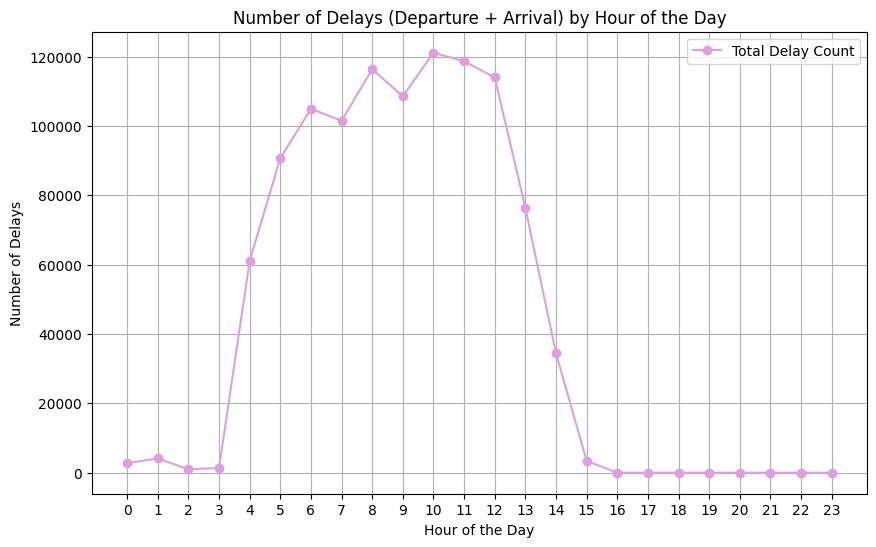

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert DepTime and ArrTime to hours, handle 24-hour clock properly
df['DepHour'] = (df['DepTime'] // 100) + (df['DepTime'] % 100) / 60.0
df['ArrHour'] = (df['ArrTime'] // 100) + (df['ArrTime'] % 100) / 60.0

# Round hours for better grouping, particularly if you're dealing with fractional hours
df['DepHour'] = df['DepHour'].round()
df['ArrHour'] = df['ArrHour'].round()

# Filter the dataset to include only rows with delays (either DepDelay or ArrDelay > 0)
df_delayed = df[(df['DepDelay'] > 0) | (df['ArrDelay'] > 0)].copy()  # Make a copy to avoid SettingWithCopyWarning

# Create the 'Delay' column (combined DepDelay and ArrDelay)
df_delayed['Delay'] = df_delayed['DepDelay'] + df_delayed['ArrDelay']

# Count the total number of delays by hour for both Departure and Arrival combined (ensure full range 0-23)
delay_count_by_hour = df_delayed.groupby('DepHour').size().reindex(range(24), fill_value=0)

# Plotting the Total Delay Counts (combined Departure and Arrival) by Hour of the Day
plt.figure(figsize=(10, 6))
plt.plot(delay_count_by_hour.index, delay_count_by_hour.values, marker='o', color='plum', label='Total Delay Count')
plt.title('Number of Delays (Departure + Arrival) by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Delays')
plt.grid(True)
plt.legend()
plt.xticks(range(24))  # Ensure the x-axis includes all hours (0-23)
plt.show()

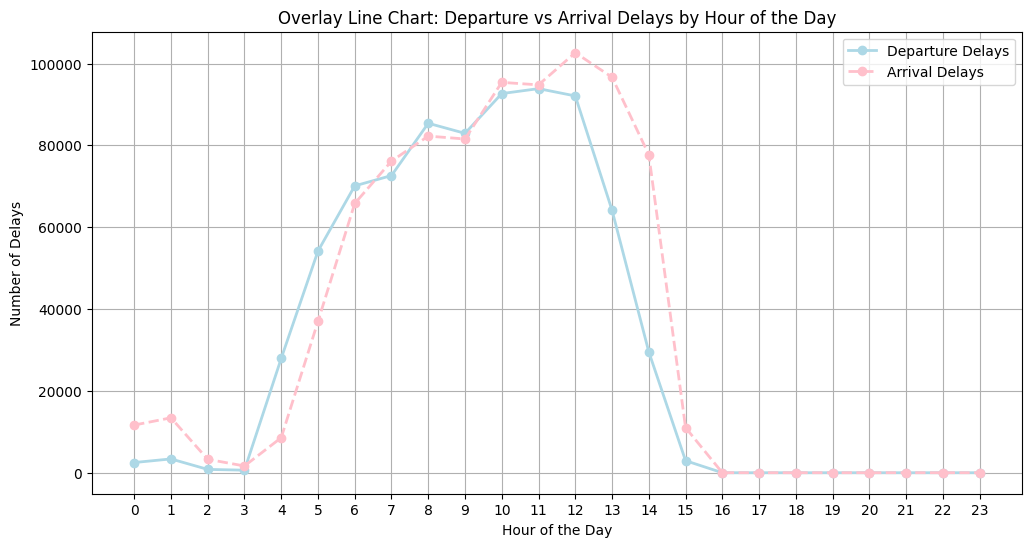

In [11]:
# Convert DepTime and ArrTime to fractional hours
df['DepHour'] = (df['DepTime'] // 100) + (df['DepTime'] % 100) / 60.0
df['ArrHour'] = (df['ArrTime'] // 100) + (df['ArrTime'] % 100) / 60.0

# Round to nearest hour for grouping
df['DepHour'] = df['DepHour'].round()
df['ArrHour'] = df['ArrHour'].round()

# Filter only rows with delays
df_delayed = df[(df['DepDelay'] > 0) | (df['ArrDelay'] > 0)].copy()

# Count number of departure delays by hour
dep_delay_count_by_hour = (
    df_delayed[df_delayed['DepDelay'] > 0]
    .groupby('DepHour')
    .size()
    .reindex(range(24), fill_value=0)
)

# Count number of arrival delays by hour
arr_delay_count_by_hour = (
    df_delayed[df_delayed['ArrDelay'] > 0]
    .groupby('ArrHour')
    .size()
    .reindex(range(24), fill_value=0)
)

# Plotting both as separate lines
plt.figure(figsize=(12, 6))

plt.plot(dep_delay_count_by_hour.index, dep_delay_count_by_hour.values,
         marker='o', color='lightblue', linestyle='-', linewidth=2, label='Departure Delays')

plt.plot(arr_delay_count_by_hour.index, arr_delay_count_by_hour.values,
         marker='o', color='pink', linestyle='--', linewidth=2, label='Arrival Delays')

plt.title('Overlay Line Chart: Departure vs Arrival Delays by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Delays')
plt.grid(True)
plt.legend()
plt.xticks(range(24))
plt.show()


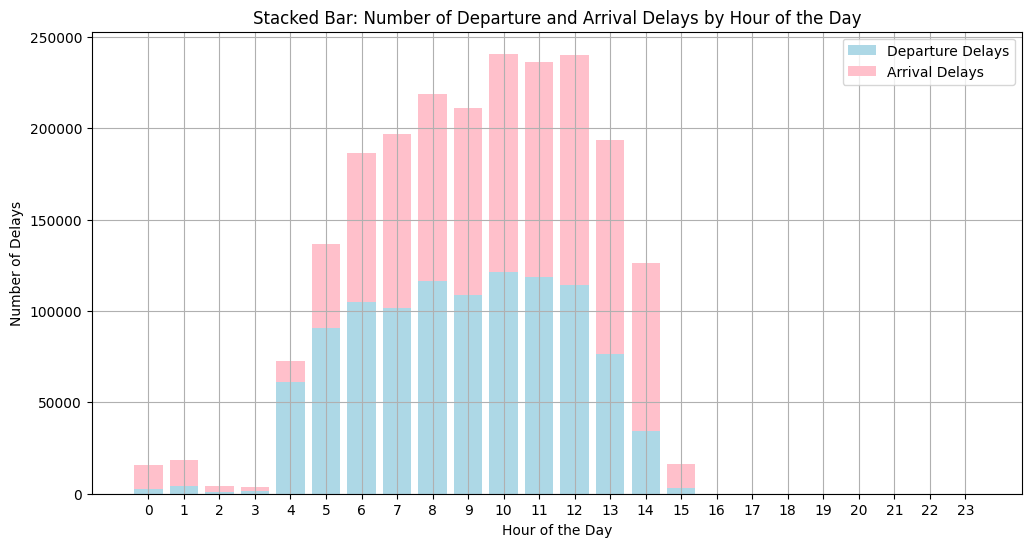

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert DepTime and ArrTime to hours, handle 24-hour clock properly
df['DepHour'] = (df['DepTime'] // 100) + (df['DepTime'] % 100) / 60.0
df['ArrHour'] = (df['ArrTime'] // 100) + (df['ArrTime'] % 100) / 60.0

# Round hours for better grouping, particularly if you're dealing with fractional hours
df['DepHour'] = df['DepHour'].round()
df['ArrHour'] = df['ArrHour'].round()

# Filter the dataset to include only rows with delays (either DepDelay or ArrDelay > 0)
df_delayed = df[(df['DepDelay'] > 0) | (df['ArrDelay'] > 0)]

# Count the number of delays by hour for Departure (ensure full range 0-23)
dep_delay_count_by_hour = df_delayed.groupby('DepHour').size().reindex(range(24), fill_value=0)

# Count the number of delays by hour for Arrival (ensure full range 0-23)
arr_delay_count_by_hour = df_delayed.groupby('ArrHour').size().reindex(range(24), fill_value=0)

# Plotting Stacked Bar Chart of Departure and Arrival Delays by Hour of the Day
plt.figure(figsize=(12, 6))

# Stacked bar chart
plt.bar(dep_delay_count_by_hour.index, dep_delay_count_by_hour.values, color='lightblue', label='Departure Delays')
plt.bar(arr_delay_count_by_hour.index, arr_delay_count_by_hour.values, bottom=dep_delay_count_by_hour.values, color='pink', label='Arrival Delays')

# Titles and labels
plt.title('Stacked Bar: Number of Departure and Arrival Delays by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Delays')
plt.xticks(range(24))  # Ensure the x-axis includes all hours (0-23)
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


In [1]:
import pandas as pd

# Load your dataset
df = pd.read_csv("cleaned_flight_data.csv", encoding="ISO-8859-1", low_memory=False)

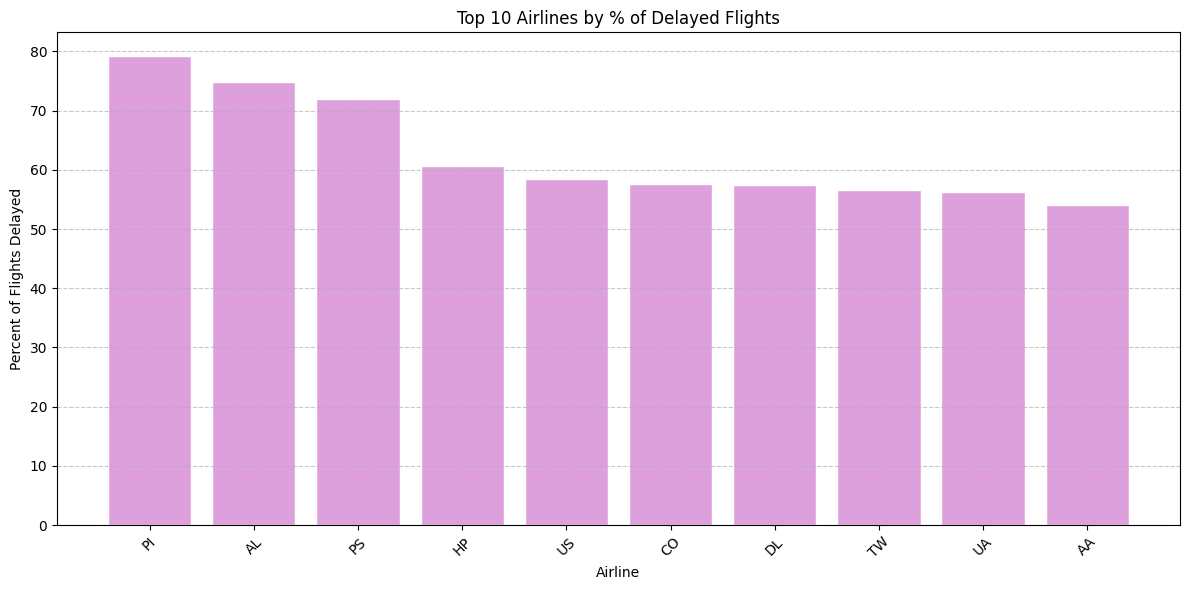

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Select the needed columns and make a copy to avoid SettingWithCopyWarning
data = df[['IATA_CODE_Reporting_Airline', 'DepDelay', 'ArrDelay', 'Flights']].copy()

# Step 2: Create the 'Delay' column
data.loc[:, 'Delay'] = ((data['DepDelay'] > 0) | (data['ArrDelay'] > 0)).astype(int)

# Step 3: Get total flights per airline
alldata = data[['IATA_CODE_Reporting_Airline', 'Flights']]
alldata = alldata.groupby('IATA_CODE_Reporting_Airline').sum().reset_index()
alldata.columns = ['Airline', 'Flights']

# Step 4: Get number of delayed flights per airline
delay_data = data[['IATA_CODE_Reporting_Airline', 'Delay']]
delay_data = delay_data.groupby('IATA_CODE_Reporting_Airline').sum().reset_index()
delay_data.columns = ['Airline', 'Delayed']

# Step 5: Merge total flights and delayed flights
ratio_data = pd.merge(alldata, delay_data, on='Airline', how='left')
ratio_data['Delayed'] = ratio_data['Delayed'].fillna(0)  # In case no delays for some airlines
ratio_data['Percent Delayed'] = (ratio_data['Delayed'] / ratio_data['Flights']) * 100

# Step 6: Sort by % delayed and take Top 10
ratio_data = ratio_data.sort_values('Percent Delayed', ascending=False).head(10)

# Step 7: Plot
plt.figure(figsize=(12, 6))
plt.bar(ratio_data['Airline'], ratio_data['Percent Delayed'], color='plum', edgecolor='white')
plt.title('Top 10 Airlines by % of Delayed Flights')
plt.xlabel('Airline')
plt.ylabel('Percent of Flights Delayed')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
# Step 1: Select the needed columns and make a copy to avoid SettingWithCopyWarning
df_selected = df[['DayOfWeek', 'DepDelay', 'ArrDelay', 'Flights']].copy()

# Check if the flight is on a weekend (Saturday=6, Sunday=7)
df_selected['IsWeekend'] = df_selected['DayOfWeek'].isin([6, 7]).astype(int)

df_selected.columns = df_selected.columns.str.strip()  # Remove leading/trailing spaces

# Check if either departure or arrival delay > 0 minutes
df_selected['Delay'] = ((df_selected['DepDelay'] > 0) | (df_selected['ArrDelay'] > 0)).astype(int)

# Calculate the correlation between IsWeekend and Delay
correlation = df_selected[['IsWeekend', 'Delay']].corr()

# Print the correlation matrix
print("Correlation between IsWeekend and Delay:")
print(correlation)

Correlation between IsWeekend and Delay:
           IsWeekend     Delay
IsWeekend   1.000000 -0.021793
Delay      -0.021793  1.000000


In [17]:
# Step 1: Select the needed columns and make a copy to avoid SettingWithCopyWarning
df_selected = df[['DayOfWeek', 'DepDelay', 'ArrDelay', 'Flights']].copy()

# Check if the flight is on a weekday (Monday = 1, Tuesday = 2, Wednesday = 3, Thursday = 4, Friday = 5)
df_selected['IsWeekday'] = df_selected['DayOfWeek'].isin([1, 2, 3, 4, 5]).astype(int)

df_selected.columns = df_selected.columns.str.strip()  # Remove leading/trailing spaces

# Check if either departure or arrival delay > 0 minutes
df_selected['Delay'] = ((df_selected['DepDelay'] > 0) | (df_selected['ArrDelay'] > 0)).astype(int)

# Calculate the correlation between IsWeekend and Delay
correlation = df_selected[['IsWeekday', 'Delay']].corr()

# Print the correlation matrix
print("Correlation between IsWeekday and Delay:")
print(correlation)

Correlation between IsWeekday and Delay:
           IsWeekday     Delay
IsWeekday   1.000000  0.021793
Delay       0.021793  1.000000


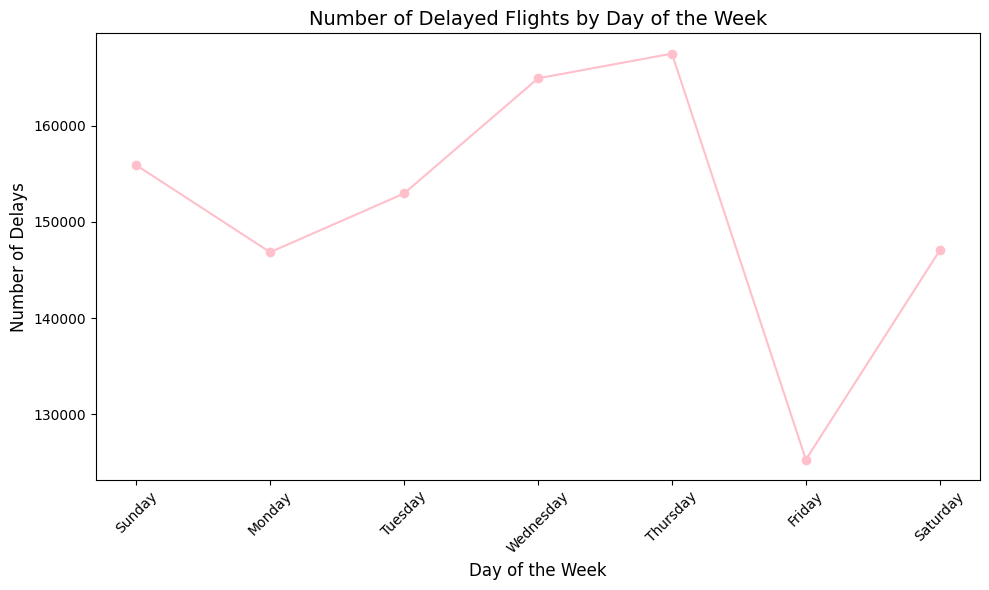

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your original DataFrame

# Step 1: Create the 'Delay' column
df['Delay'] = ((df['DepDelay'] > 0) | (df['ArrDelay'] > 0)).astype(int)

# Step 2: Group by DayOfWeek and sum the delays (1 means delayed)
delay_by_day = df.groupby('DayOfWeek')['Delay'].sum().reset_index()

# Step 3: Map DayOfWeek values to their respective names
day_map = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
           5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
delay_by_day['Day'] = delay_by_day['DayOfWeek'].map(day_map)

# Step 4: Sort the data by DayOfWeek for proper chronological order
delay_by_day = delay_by_day.sort_values('DayOfWeek', ignore_index=True)

# Step 5: Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(delay_by_day['Day'], delay_by_day['Delay'], marker='o', linestyle='-', color='pink')

# Step 6: Add labels and title
plt.title('Number of Delayed Flights by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Step 7: Display the plot
plt.tight_layout()
plt.show()

Top tail numbers with the most delays:
Tail_Number
N963DL    263
N956DL    254
N904DE    252
N972DL    251
N912DE    250
N961DL    250
N944DL    250
N955DL    246
N951DL    245
N997DL    244
Name: count, dtype: int64


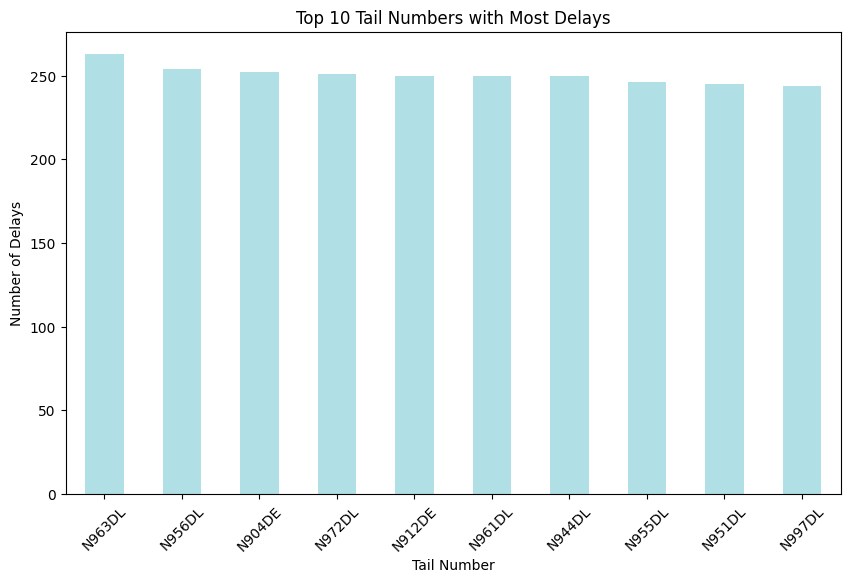

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already loaded your dataset into a DataFrame called df
# Make sure 'Delay' column is created (1 for delayed, 0 for on time)

# Check for delayed flights by TailNumber
tail_number_delays = df[df['Delay'] == 1]['Tail_Number'].value_counts()

# Display the tail numbers with the most delays
print("Top tail numbers with the most delays:")
print(tail_number_delays.head(10))  # Top 10 tail numbers with the most delays

# Plot the delays per TailNumber
plt.figure(figsize=(10, 6))
tail_number_delays.head(10).plot(kind='bar', color='powderblue')
plt.title('Top 10 Tail Numbers with Most Delays')
plt.xlabel('Tail Number')
plt.ylabel('Number of Delays')
plt.xticks(rotation=45)
plt.show()